# How to use the Multiparameter Module Approximation library.
This notebook provides a detailed example using the main functions of this library.

## Setup

The easiest way to compile / install this python library is using pip :

In [1]:
# !pip install custom_vineyards/

If you want to directly compile it, you can use the following command, which will create a `*.so` in the root folder, which can be imported using python.

In [2]:
#!cd custom_vineyards/ && CC='ccache gcc' python setup.py build_ext -j4 && find build/ -name "*.so" -exec mv {} ../ \; && rm -r build

In [3]:
import matplotlib.pyplot as plt		# Plot library of Python.
import gudhi as gd   				# TDA library. This will help us generate chain complexes with the simplextree structure.
import numpy as np   				# As math in python is broken we need numpy 
from mma import * 					# Our python library to approximate n-persistence modules.

## Typical pipeline.

### Take a simplextree
In this case we will take a simple simplextree, but in a "real usecase" you will want to take a simplextree generated via a dataset. 

In [4]:
s = gd.SimplexTree()
s.insert([0,1,4])
s.insert([0,3,4])
s.insert([1,3,4])
s.insert([0,2,5])
s.insert([0,3,5])
s.insert([1,2,5])
s.insert([1,3,5])
s.insert([6,7,9])
s.insert([6,8,9])
s.insert([7,8,9])
s.insert([6,7,10])
s.insert([6,8,10])
s.insert([7,8,10])

True

### Consider a bi-filtration (ie. a list of filtrations of the simplices)

In general you can give as an input an `n`-filtration, but we will stick to `n=2` for the moment, to have access to the plot functions. <br>
If the filtration is given by the filtration that is not complete (eg. only given on the points), it will automatically be completed via a lower star filtration. 

In [5]:
F1 = np.array([1,1,1,4,5,4,4,4,4,4,5])
F2 = np.array([1,1,4,1,5,4,4,4,4,5,4])
F = [F1,F2] # or np.hstack([F1[:,np.newaxis], F2[:,np.newaxis]])

### Consider a rectangle box on which to compute vineyards

Format : [x,y], where x,y defines the rectangle {z : x ≤ z ≤ y}. 

In [6]:
box = [[0,0], [8,8]]

All of the lines intersecting this box will be computed (up to the `precision` defined below), if no box is given, it will generate one depending on the filtration values

### Precision and number of lines

By default, the custom algorithm will ask for a precision parameter which the control in term of bottleneck distance (and thus interleaving distance) of the approximation.

In [7]:
precision = 0.01

One can also convert the number of computed lines to a precision value with the function

In [8]:
def nlines_to_precision(nlines, box, fix_box=True):
    import math
    h = abs(box[1][-1] - box[0][-1])
    filtration_dimension = len(box[0])
    scale = np.linalg.norm((np.array(box[1])[:-1] - np.array(box[0])[:-1]) + h,1)
    precision = (scale / nlines)**(1/(filtration_dimension -1))
    if fix_box: 
        # The following makes the box edges length a multiple of precision
        for i in range(filtration_dimension-1):
            box[1][i] -= math.fmod(box[1][i]-box[0][i] + h, precision)
            if box[1][i] - box[0][i] < precision:
                box[1][i] += precision
    return precision

In [9]:
nlines = 200
precision = nlines_to_precision(nlines,box)
precision

0.08

### Compute `n`-module approximations and fibered matched barcodes

Approximation. The format is : [[ [birth_corner_list, death_corner_list] for summand] for dimension]

In [10]:
bimodule_approximation = approx(s, F, precision, box)

There are other parameters :

- `dimension=-1` (int) makes the algorithm only return the summands of the asked dimension.
- `threshold=False` If set to `True`,  intersects the summands with the box (for plot purposes).
- `verbose = False` : If set to `True`, the `C++` code will give some information about the computation,
- `keep_order=False` : If set to true, will keep the summands (and their plot color) ordered at a small computational overhead,
- `complete = True` : if set to `True` plots more natural candidates, with a small compuation overhead,
- `multithread = False` : if set to `True`, it will use multiple threads (there are some issues for the moment).

Matched barcodes. The format is : [[[birth, death] for line] for summand] for dimension]

In [11]:
barcodes = vine_alt(s, F, precision, box)

It takes the same arguments as the upper function, and returns an interval approximation for each summand as a list of birth corners, and death corners (see definition from paper)

### Sparse matrix backend

This code doesn't take as an input simplextrees, but sparse boundary matrices. All of the functions can take as an imput a simplextree, but they call, if necessary, the following function to convert a simplex tree to a sparse boundary matrix.

In [12]:
boundary_matrix = simplextree_to_sparse_boundary(s) 

One can call the functions with a boundary matrix instead of a simplex tree as a parameter.

In [13]:
barcodes = vine_alt(boundary_matrix, F, precision, box)
bimodule_approximation = approx(boundary_matrix, F, precision, box)

## Plotting in 2d

We can produce a 2D plot from a bi-filtered simplextree (or boundary matrix). The function `plot_vine_2d` takes the same inputs as the one before but one has to specify the dimension.

Candidat bi-module plot. This plots the bi-module approximation. Each color represent a different summand.

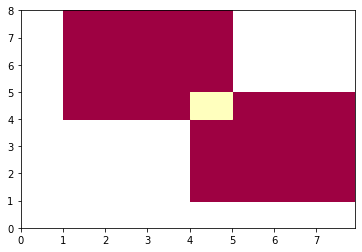

In [14]:
plot_approx_2d(s, F, precision, box, dimension = 1)

This plot function has some optional parameters :

- `return_corners=False` : if set to `True`, makes this algorithm also return the generator & relations used to plot the approximation bimodule,
- `separated = False` : if set to `True`, makes a different plot for each summand,
- `min_interleaving = 0` : the summands that are `min_interleaving`-interleaved with the `0` bimodule are not plotted,
- `complete = True` : if set to `True` plots more natural candidates, with a small compuation overhead,
- `alpha = 1`		: set the alpha value of the summand's color,
- `verbose = False` : If set to `True`, the `C++` code will give some information about the computation,
- `keep_order=False` : If set to true, will keep the summands (and their plot color) ordered at a small computational overhead,
- `shapely = True` : if `True` and `alpha` is lower than 1, this will call the shapely library to output a correct plot (Recommended).
- `save = False` : if nonempty, saves the figure as the string contained in `save`,
- `dpi = 50` : sets the dpi of the saved figure,
- `multithread = False` : if set to `True`, it will use multiple threads (there are some issues for the moment).

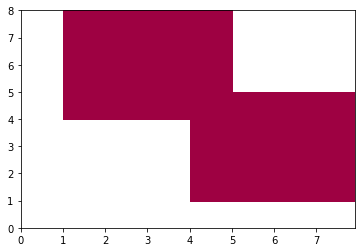

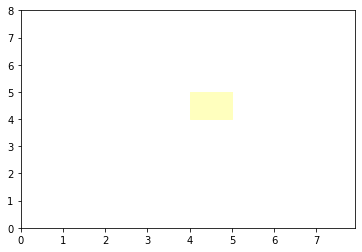

In [15]:
plot_approx_2d(s, F, precision, box, dimension = 1, separated=1)

One can plot (much slower) the matched fibered barcodes with the following function taking the (some of the) same arguments. 

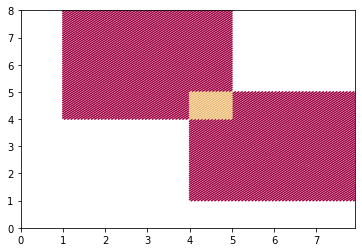

In [16]:
plot_vine_2d(s, F, precision, box, dimension = 1)

#### Other approximation examples (See the notebook `examples_of_approximations` for details and more detailed examples)

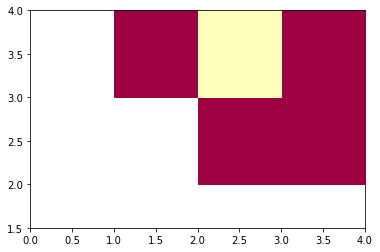

In [17]:
simplextree = gd.SimplexTree()
simplextree.insert([0])
simplextree.insert([1])
simplextree.insert([2])
simplextree.insert([3])
simplextree.insert([4])
simplextree.insert([5])
simplextree.insert([0, 1])
simplextree.insert([0, 3])
simplextree.insert([1, 2])
simplextree.insert([2, 3])
simplextree.insert([2, 4])
simplextree.insert([1, 4])
simplextree.insert([3, 4])
simplextree.insert([1, 5])
simplextree.insert([3, 5])
simplextree.insert([4, 5])
simplextree.insert([1, 2, 4])
simplextree.insert([2, 3, 4])
simplextree.insert([1, 4, 5])
simplextree.insert([3, 4, 5])
filtration = np.array([[1, 1],[1, 2],[2, 2],[1, 2],[3, 2.5],[1, 3]])

plot_approx_2d(simplextree, filtration, 0.05, box=[[0,1.5],[4,4]], dimension=1, separated=0)

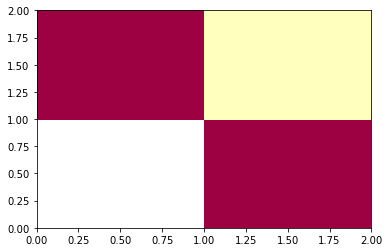

[([[0.0, 1.0], [1.0, 0.0]], [[2.0, 2.0]]),
 ([[0.9999999999999999, 1.0]], [[2.0, 2.0]])]

In [18]:
simplextree = gd.SimplexTree()
simplextree.insert([0,3])
simplextree.insert([1,3])
simplextree.insert([2])
F1 = np.array([0,1,1,1])
F2 = np.array([1,0,1,1])
filters = np.hstack([F1[:,np.newaxis], F2[:,np.newaxis]])
plot_approx_2d(simplextree, filters, 0.1, box=[[0,0],[2,2]],dimension=0, return_corners=1)


## Filtered Simplextree with density pipeline

In [19]:
from benchmark_functions import noisy_annulus
from sklearn.neighbors import KernelDensity

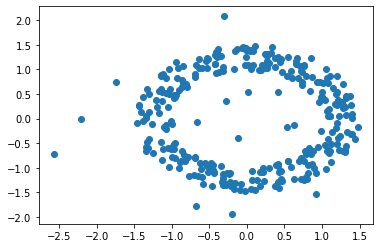

In [20]:
npts = 300
noutliers = npts * 0.05
X = np.array(noisy_annulus(1,1.5, npts) + noisy_annulus(0,0.7, (int)(noutliers/2)) + noisy_annulus(1.6,3, (int)(noutliers/2)) )
plt.scatter(X[:,0], X[:,1])

In [21]:
nlines = 100
simplextree = gd.AlphaComplex(points=X).create_simplex_tree()

kde = KernelDensity(kernel='gaussian', bandwidth=.3).fit(X)

filtration_dens = -np.array(kde.score_samples(X))
filtration_alpha = np.array([simplextree.filtration(s) for s,_ in simplextree.get_simplices()])
to_complete_filtration = [filtration_alpha, filtration_dens]
boundary, filters = ls_boundary_density(simplextree, to_complete_filtration, to_permute=[0])

box = [[0,1.5], [1.5,4]]
precision = nlines_to_precision(nlines,box)

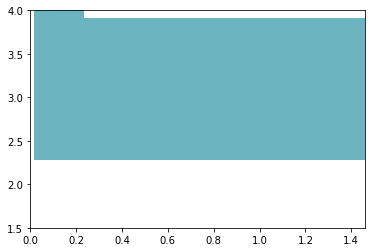

CPU times: user 136 ms, sys: 8.11 ms, total: 144 ms
Wall time: 142 ms


In [22]:
%time plot_approx_2d(boundary, filters,precision, box, dimension=1, complete=1, alpha = 0.8, min_interleaving=0.2, separated = 0, keep_order = 1)

We can see in that example that there is only 1 significant summand (ie. summand that is not `min_interleaving=0.2`-interleaved with `0`) as `separated=1` of dimension 1 representing the circle.

## Higher dimensions

The same syntax applies in higher persistence dimension : 

In [23]:
max_dim = 5
n = simplextree.num_simplices()
print(n)
# We take a random filtration of the form
F = [[np.random.uniform(low = 0, high = 1) for _ in range(n)] for _ in range(max_dim)]
# And a random box of the same dimension 
box = [[np.random.uniform(low = 0, high = 1) for _ in range(max_dim)], [np.random.uniform(low = 2, high = 3)for _ in range(max_dim)]]
precision=1

1853


In [24]:
%time multidim_barcodes = vine_alt(simplextree, F, precision, box);

CPU times: user 11.5 s, sys: 95.6 ms, total: 11.6 s
Wall time: 11.5 s


In [25]:
%time n_mod_approximation = approx(simplextree, F, precision, box, complete = 1);

CPU times: user 11.2 s, sys: 20.1 ms, total: 11.3 s
Wall time: 11.2 s


But there is no plotting function in higher dimension.